# Working with MNIST
* Exploring how to load MNIST dataset from scratch

## Necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os
import multiprocessing
from requests import get
import pickle

## Class for loading MNIST dataset

In [2]:
class mnist(object):
    def __init__(self):
        self.__dataset_urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
                'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
                'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
                'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']
        
        self.__training_set = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']
        self.__test_set = ['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
        self.__dataset = self.__training_set + self.__test_set
        self.__dataset_exists = lambda file_list : list(map(os.path.isfile, file_list))
    
    def __download_file_util(self, url):
        file_name = os.path.basename(url)
        print('Downloading: ', url)
        with open(file_name, 'wb') as file:
            response = get(url)
            file.write(response.content)
    
    def __download_dataset(self, dataset_urls):
        '''
        Initially, I wrote this piece of code but got to know that we need
        to do some workaround to be able to use multiprocessing's pool 
        inside a class. Therefore, the below piece of code doesn't work as expected
        
        # n_cpu = multiprocessing.cpu_count()
        # with multiprocessing.Pool(processes=n_cpu) as pool:
        # pool.map(mnist.download_file_util, dataset_urls)

        '''
        
        jobs = []
        for url in dataset_urls:
            p = multiprocessing.Process(target=self.__download_file_util, args=(url,))
            jobs.append(p)
            p.start()
        
        for p in jobs:
            p.join()
        
    def __read_mnist_data(self, dataset):
        feature_file_path, label_file_path = (dataset[0], dataset[1])

        with gzip.open(label_file_path, 'rb') as label_file:
            labels = np.frombuffer(label_file.read(), dtype=np.uint8, offset=8)

        with gzip.open(feature_file_path, 'rb') as feature_file:
            length = len(labels)
            features = np.frombuffer(feature_file.read(), dtype=np.uint8, offset=16).reshape(length, 784)             .reshape(length, 28, 28, 1)

        return features, labels
    
    def load_data(self):
        
        if not all(self.__dataset_exists(self.__dataset)):
            self.__download_dataset(self.__dataset_urls)
        
        X_train, y_train = self.__read_mnist_data(self.__training_set)
        X_test, y_test = self.__read_mnist_data(self.__test_set)
        
        '''
            originally size of image is 28x28
            we have to pad it to make it of size 32x32
        '''
        ## padding 
        pad_dims = ((0, 0), (2, 2), (2, 2), (0, 0))
        pad_type_str = 'constant'
        X_train = np.pad(X_train, pad_dims, pad_type_str)
        X_test = np.pad(X_test, pad_dims, pad_type_str)
        
        return X_train, y_train, X_test, y_test
    
    def display_image(self, idx, X_tmp):
        if X_tmp.shape[1:] != (32, 32, 1):
            print('Invalid shape image provided')
        else:
            image = X_tmp[idx].squeeze()
            plt.title('Example %d: ' % (idx))
            plt.imshow(image, cmap=plt.cm.gray_r)

## Initialize

In [3]:
mnist_data = mnist()

## Load MNIST data 

In [4]:
X_train, y_train, X_test, y_test = mnist_data.load_data()

print('==== Printing shapes of data ===')
print()
print('Train data:      ', X_train.shape, y_train.shape)
print('Test data:       ', X_test.shape, y_test.shape)

Downloading:  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Downloading:  http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Downloading:  http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Downloading:  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
==== Printing shapes of data ===

Train data:       (60000, 32, 32, 1) (60000,)
Test data:        (10000, 32, 32, 1) (10000,)


## Display an image from loaded dataset

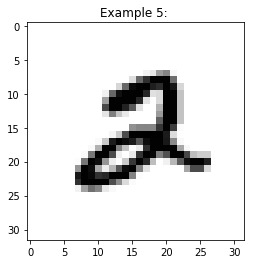

In [5]:
mnist_data.display_image(idx=5, X_tmp=X_train)

# References
* https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9#scrollTo=1w66ueiLlP0k